# MAP-rSO<sub>2</sub> plotting experiment

Simo Mäkelä  
Helsinki Metropolia University of Applied Sciences  
25.8.2020

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import zoll
import nirs
import utils

In [2]:
filename = 'AR18F032727-20200113-114412-690'
json = zoll.LoadJSON("data/" + filename + ".json")

In [3]:
bp_df, bp_samplerate = zoll.LoadWaveform(json, hide_starttime=True)

Duration:         3164.28 s

Total samples:     395535      Discarded:    3383
Sample rate:          125 1/s  Sample time:  8000 μs


In [4]:
def ComputeAverage(waveform, window, samplerate, win_type=None):
    win = window * samplerate
    return waveform.rolling(win, win_type=win_type).mean()

In [5]:
bp_df['MAP 10'] = ComputeAverage(bp_df['Waveform'], 10, bp_samplerate)
bp_df['MAP 60'] = ComputeAverage(bp_df['Waveform'], 60, bp_samplerate)
bp_df['MAP 150'] = ComputeAverage(bp_df['Waveform'], 150, bp_samplerate)
bp_df['MAP 300'] = ComputeAverage(bp_df['Waveform'], 300, bp_samplerate)
bp_df['MAP 600'] = ComputeAverage(bp_df['Waveform'], 600, bp_samplerate)

In [6]:
# merge with NIRS (rSO2) data
nirs_df = nirs.LoadCSV("data/" + filename + ".csv")
df = pd.merge_asof(nirs_df['rSO2'], bp_df[['MAP 10', 'MAP 60', 'MAP 150', 'MAP 300', 'MAP 600']], on='Time', direction='nearest')

utils.NormalizeTime(df)
t_start, t_end = utils.CreateElapsedTimeColumn(df) # for colormap

df.set_index('Time', inplace=True)

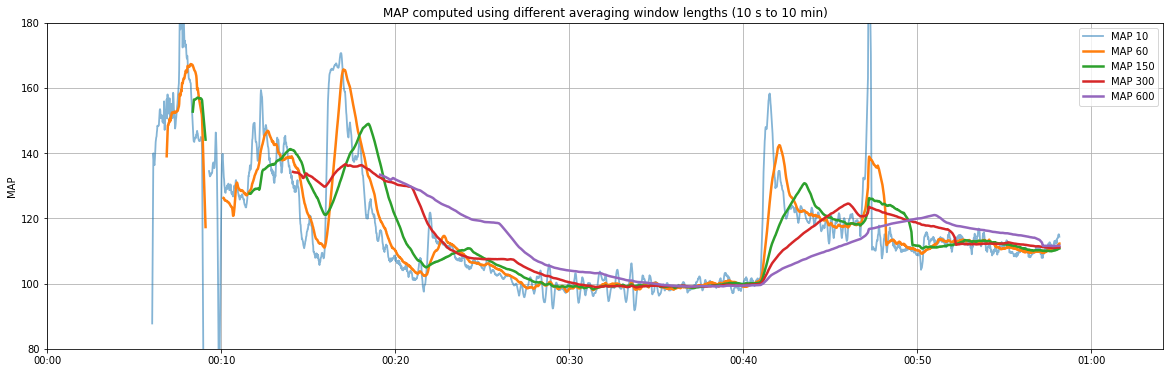

In [20]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_xlim(t_start, t_end)
ax.set_ylabel('MAP')
ax.set_ylim(80, 180)
ax.plot(df.index, df['MAP 10'], linewidth=1.8, alpha=0.55)
ax.plot(df.index, df[['MAP 60', 'MAP 150', 'MAP 300', 'MAP 600']], linewidth=2.5)
ax.grid()
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title("MAP computed using different averaging window lengths (10 s to 10 min)")
plt.legend(labels=['MAP 10', 'MAP 60', 'MAP 150', 'MAP 300', 'MAP 600'], loc="upper right")
plt.show()

In [8]:
df['rSO2 60'] = ComputeAverage(df['rSO2'], 60, 1)
df['rSO2 150'] = ComputeAverage(df['rSO2'], 150, 1)
df['rSO2 300'] = ComputeAverage(df['rSO2'], 300, 1)
df['rSO2 600'] = ComputeAverage(df['rSO2'], 600, 1)

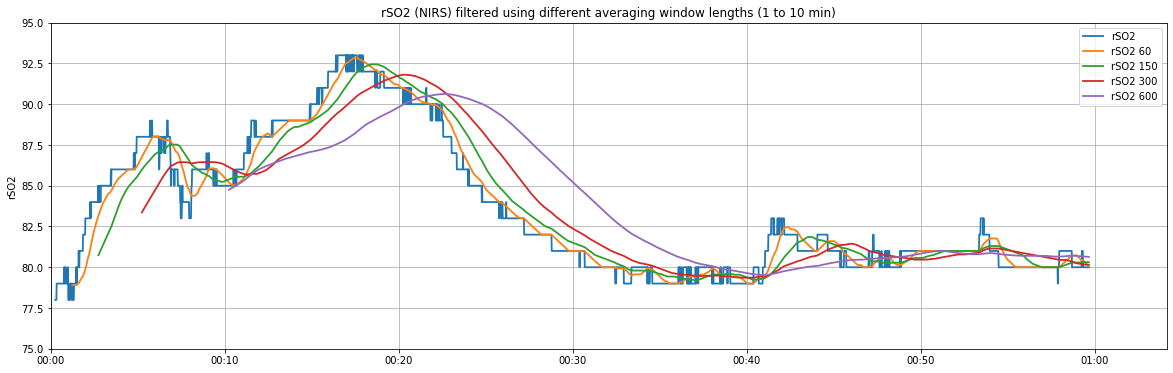

In [22]:
fig, ax = plt.subplots(figsize=(20,6))
ax.set_xlim(t_start, t_end)
ax.set_ylabel('rSO2')
ax.set_ylim(75, 95)
ax.plot(df.index, df[['rSO2', 'rSO2 60', 'rSO2 150', 'rSO2 300', 'rSO2 600']], linewidth=1.8)
ax.grid()
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
plt.title("rSO2 (NIRS) filtered using different averaging window lengths (1 to 10 min)")
plt.legend(labels=['rSO2', 'rSO2 60', 'rSO2 150', 'rSO2 300', 'rSO2 600'], loc='upper right')
plt.show()

In [10]:
def plot(x, y, c):
    fig, ax = plt.subplots(figsize=(20,6))
    ax.set_xlim((90,180))
    ax.set_ylim((77,94))
    ax.set_xlabel(x.name)
    ax.set_ylabel(y.name)
    cb_label = c.name
    x = x.values
    y = y.values
    c = c.values
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    cmap = plt.get_cmap('viridis_r')
    norm = plt.Normalize(0, 1)
    lc = mpl.collections.LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(c)
    lc.set_linewidth(2)
    ax.add_collection(lc)
    #ax.scatter(x, y, c='k', s=7, cmap=cmap, alpha=0.3) # dot markers
    #_=plt.setp(ax.xaxis.get_majorticklabels(), rotation=70 )
    cbaxes = fig.add_axes([0.875, 0.15, 0.01, 0.7]) # left, bottom, width, height
    fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                cax=cbaxes, orientation='vertical', label=cb_label)
    cbaxes.yaxis.tick_left()
    plt.show()

In [11]:
def plot_timeline(abp, nirs, title, start, end):
    fig, ax1 = plt.subplots(figsize=(20,6))
    ax1.set_xlim([start, end])
    ax1.set_ylabel('rSO2', color='navy')
    ax1.set_ylim(75, 100)
    line1 = ax1.plot(df.index, nirs, color='navy', label='rSO2')
    ax1.tick_params(axis='y', labelcolor='navy')
    ax2 = ax1.twinx()
    ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter('%H:%M'))
    ax2.set_ylabel('MAP', color='maroon')
    ax2.set_ylim(80, 180)
    line2 = ax2.plot(df.index, abp, color='maroon', label='MAP')
    ax2.tick_params(axis='y', labelcolor='maroon')
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels, loc='upper right')
    ax2.grid()
    plt.title(title)
    cbaxes = fig.add_axes([0.125, 0.146, 0.7255, 0.02]) # left, bottom, width, height
    fig.colorbar(mpl.cm.ScalarMappable(norm=plt.Normalize(0, 1), cmap=plt.get_cmap('viridis_r')),
                cax=cbaxes, orientation='horizontal')
    cbaxes.xaxis.set_visible(False)
    plt.show()

## 60 second moving average:

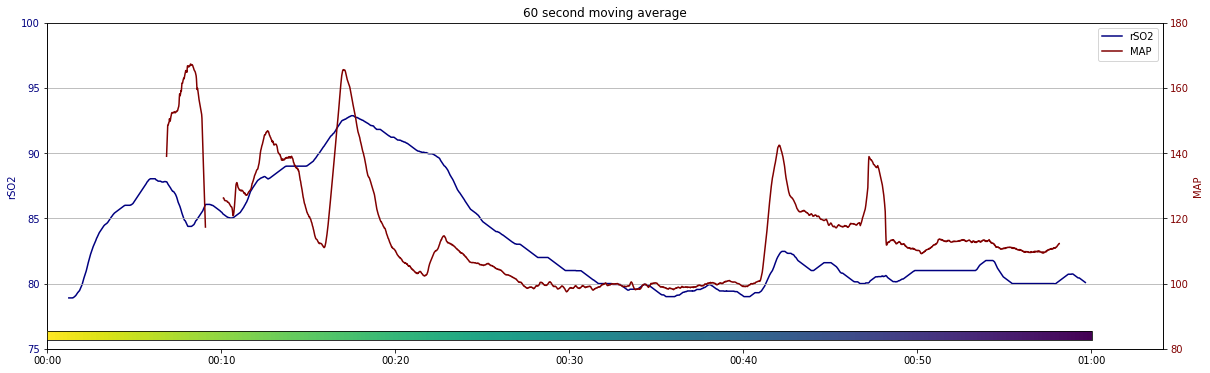

In [12]:
plot_timeline(df['MAP 60'], df['rSO2 60'], "60 second moving average", t_start, t_end)

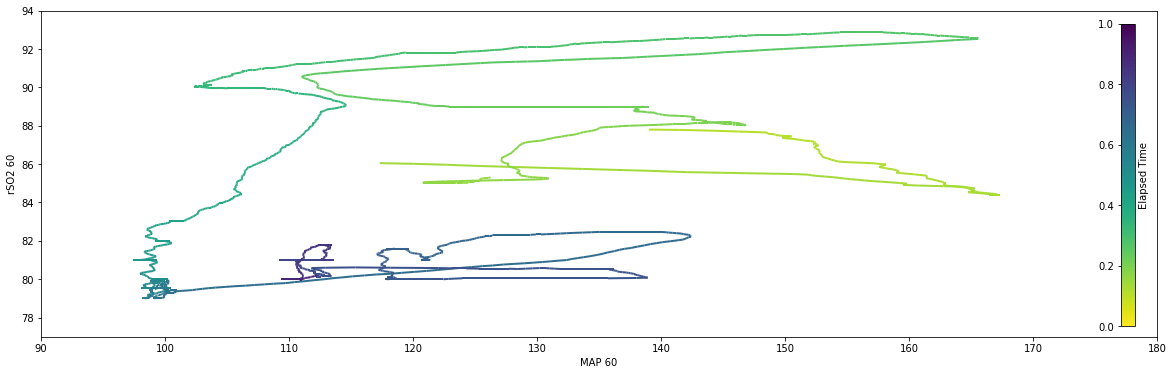

In [13]:
plot(df['MAP 60'], df['rSO2 60'], df['Elapsed Time'])

## 150 second moving average:

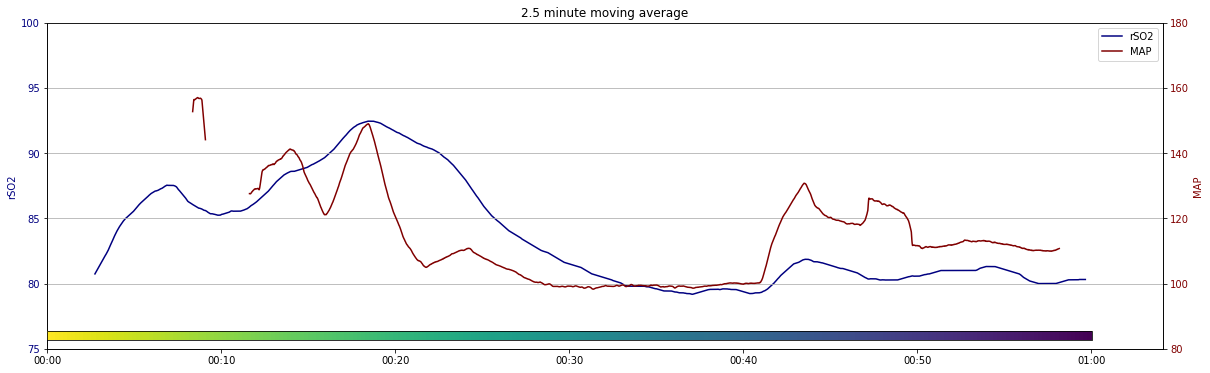

In [14]:
plot_timeline(df['MAP 150'], df['rSO2 150'], "2.5 minute moving average", t_start, t_end)

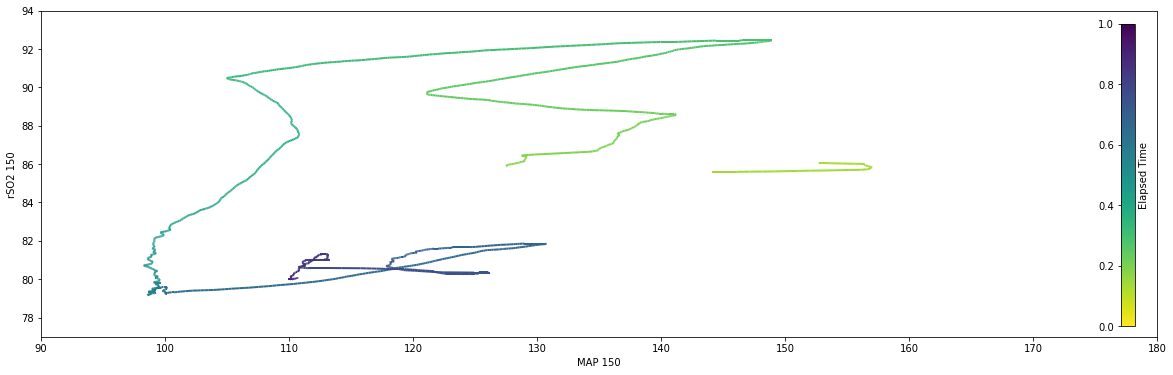

In [15]:
plot(df['MAP 150'], df['rSO2 150'], df['Elapsed Time'])

## 300 second moving average:

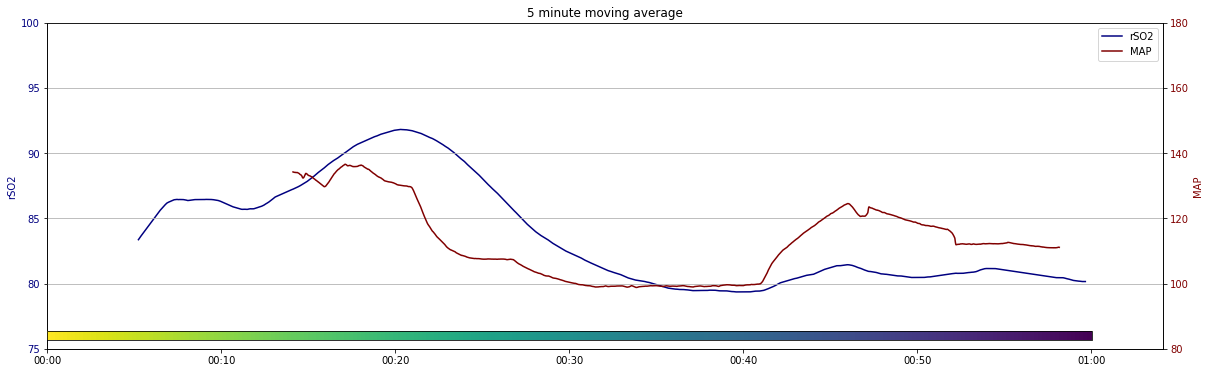

In [16]:
plot_timeline(df['MAP 300'], df['rSO2 300'], "5 minute moving average", t_start, t_end)

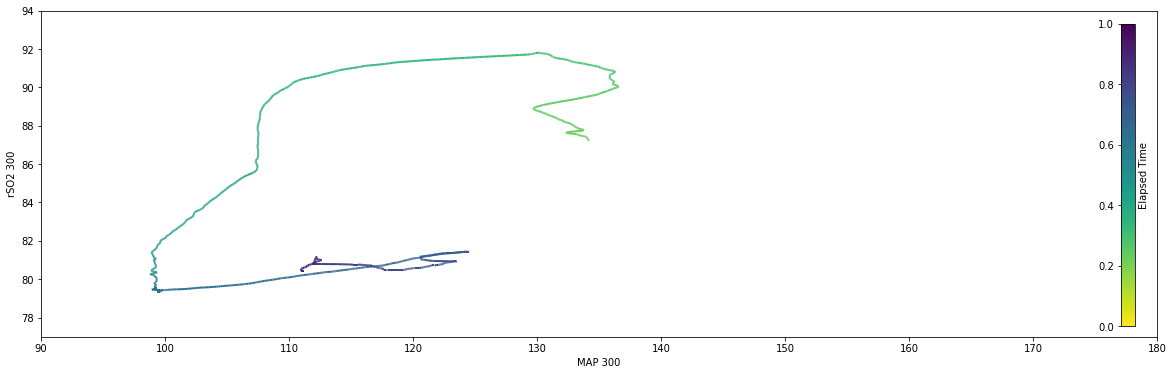

In [17]:
plot(df['MAP 300'], df['rSO2 300'], df['Elapsed Time'])

## 600 second moving average:

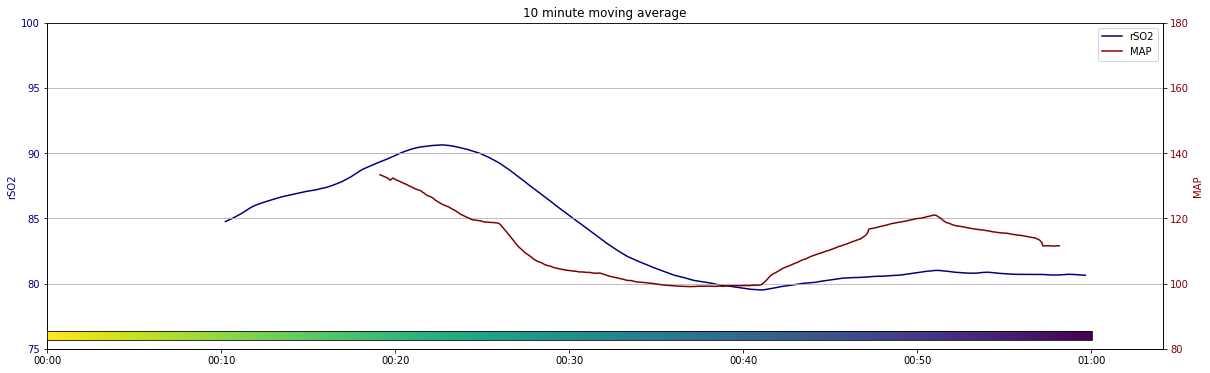

In [18]:
plot_timeline(df['MAP 600'], df['rSO2 600'], "10 minute moving average", t_start, t_end)

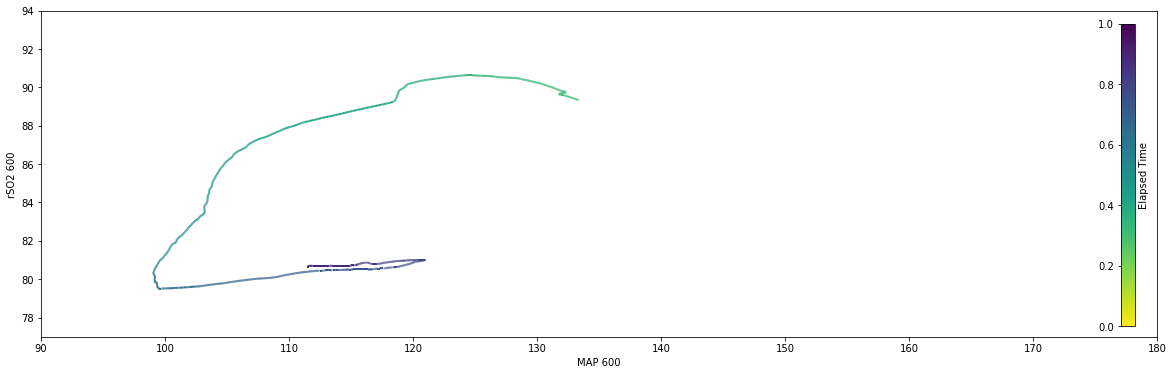

In [19]:
plot(df['MAP 600'], df['rSO2 600'], df['Elapsed Time'])